In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go

import matplotlib
import plotly
import sklearn
import torch

from IPython.display import display
plt.style.use("ggplot")

print("package版本信息：")
print("numpy:      ", np.__version__)
print("pandas:     ", pd.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn:    ", sklearn.__version__)
print("seaborn:    ", sns.__version__)
print("plotly:     ", plotly.__version__)
print("PyTorch:     ", torch.__version__)

package版本信息：
numpy:       1.19.2
pandas:      1.0.1
matplotlib:  3.3.1
sklearn:     0.23.2
seaborn:     0.11.1
plotly:      4.14.1
PyTorch:      1.2.0


# Tensor基础

PyTorch的设计遵循着 **Tensor(高维数组) ——> Varible(自动求导AutoGrad) ——> nn.Module(神经网络层/模块)** 三个由低到高的抽象层次.

## 创建Tensor

有两种方式可以创建Tensor：
1. 使用`torch.Tensor()`构造方法，注意，这是`torch.Tensor`类的构造器方法
2. 使用`torch.xxx()`函数来创建Tensor，比如：
  + `torch.tensor(data, dtype=None, device=None, requires_grad=False,)`——这是静态函数，用于从已有数据中创建tensor，注意这里的`requires_grad`参数。
  + `torch.ones()`
  + `torch.zeros()`
  
上述两种方法都会返回`torch.Tensor`的对象。

有关`torch.Tensor()`方法和`torch.tensor()`方法的讨论见问答 [What is the difference between torch.tensor and torch.Tensor?](https://stackoverflow.com/questions/51911749/what-is-the-difference-between-torch-tensor-and-torch-tensor).

+ 基本创建

In [29]:
# 使用构造方法，指定tensor的shape
t1 = torch.Tensor(2,3)
t1

tensor([[2.9339e+32, 7.5551e+31, 1.5089e-19],
        [4.4656e+30, 3.3917e-15, 0.0000e+00]])

In [154]:
# 使用构造方法，从 list of list 中创建
t2 = torch.Tensor([[1,2,3], [4,5,6]])
t2

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [155]:
# 使用静态方法
t3 = torch.tensor([[1,2]])
t3

tensor([[1, 2]])

+ Tensor的一些属性

In [57]:
t1.dtype

torch.float32

In [30]:
t1.size()

torch.Size([2, 3])

In [31]:
t1.shape

torch.Size([2, 3])

In [32]:
t1.numel()

6

+ 常用的创建方式

In [16]:
# 全 1 Tensor
torch.ones(2,3)

tensor([[1., 1., 1.],
        [1., 1., 1.]])

In [17]:
# 全 0 
torch.zeros(3,2)

tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])

In [18]:
# 步长
torch.arange(1, 6, 2)

tensor([1, 3, 5])

In [19]:
torch.linspace(1, 10, 3)

tensor([ 1.0000,  5.5000, 10.0000])

In [22]:
# 均匀分布随机数
torch.rand(5, 3)

tensor([[0.4395, 0.3174, 0.5914],
        [0.2081, 0.3722, 0.5950],
        [0.5110, 0.2151, 0.0040],
        [0.8960, 0.6777, 0.7021],
        [0.1643, 0.4797, 0.0276]])

In [23]:
# 正态随机数
torch.randn(3,4)

tensor([[-0.8362, -0.4455, -0.4478,  1.5865],
        [ 1.1634,  1.4463,  0.3926,  0.1785],
        [-0.8441, -1.5769, -0.8146,  0.8134]])

In [24]:
# 对角线为1
torch.eye(3,3)

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

## Tensor类型

Tensor有各种类型，并且每种类型有CPU和GPU版本。

类型之间的转换有三种方式，设已有tensor `a` 和 `b`
1. `a.type(torch.FloatTensor)`，
2. `a.float()`，便捷的方式
3. `a.as_type(b)`，使用`b`的类型来设置`a`

In [61]:
a = torch.tensor([1,2])
a.dtype

torch.int64

In [62]:
c = a.type(torch.FloatTensor)
c.dtype

torch.float32

In [63]:
c = a.float()
c.dtype

torch.float32

## 操作Tensor

In [109]:
torch.cuda.is_available()

True

-----

# Autograd

`torch.autograd` 模块是一套专门用于自动求导的引擎，能够根据输入和前向传播过程自动**动态地**构建计算图，并执行反向传播。

Autograd 模块中的核心数据结构是`Variable`，它是对Tensor的封装，同时记录了对Tensor的操作，用于构建计算图。  
`Variable`包含三个属性：
+ `data`：保存`Variable`包含的Tensor
+ `grad`：保存`data`对应的梯度，它本身也是一个`Variable`，与`data`形状一致
+ `grad_fn`：指向一个Function，记录`Variable`的操作历史，用于构建计算图。对于叶子节点，它指向的None。

注意:
> 从 **0.4 版本**开始，`torch.Tensor`和`torch.autograd.Variable`被合并到了一起。  
更确切地说，`torch.Tensor`能够像旧版`Variable`一样追踪历史，`Variable`封装还像过去那样工作，但返回一个`torch.Tensor`类型的对象。  
这意味着不再需要在代码中到处使用`Variable`封装器。

创建Tensor的时候，有两种方式让这个Tensor作为变量进行求导操作：
1. 创建时指定参数`required_grad=True`
2. 创建后通过`torch.Tensor`对象的`.required_grad`属性进行设置

注意，**只有浮点数类的Tensor才能设置求导**。

In [138]:
# 下面可以看出，Variable已经和Tensor合并了
from torch.autograd import Variable
a = Variable(torch.ones(2,3)*2, requires_grad=True)
print(a.__class__)
a

<class 'torch.Tensor'>


tensor([[2., 2., 2.],
        [2., 2., 2.]], requires_grad=True)

## 多元函数的反向求导

多元函数是 $R^n \Rightarrow R$ 的一个映射：自变量 $x \in R^n$，因变量 $y=f(x) \in R$. 这种情况下，偏导数 $\frac{\partial f}{\partial x} \in R^n$ 也是一个 $n$ 维向量.  

这里构造一个 $c = 3 \times a^2 + b^2$ 的例子，这个计算中，可以进一步拆成如下的简单四则运算的节点：
1. 节点 $a$ 和 $b$ 都是输入节点——也被称为计算图的**叶子节点**
2. 中间节点 $t_1 = a^2$，$t_2 = b^2$ 和 $t_3 = 3 \times t_1$ —— 对应于计算图的**非叶子节点**
3. 最终的节点 $c = t_3 + t_2$。

下面的代码中，为了简便起见，将 $t_1$ 和 $t_3$ 合并为一个 $t_1 = 3 \times a^2$.

In [228]:
# 注意，这里只能使用 tensor 静态方法，不能使用 torch.Tensor() 构造方法
# 这里必须是 浮点数 1.0，不能是 整数 1
a = torch.tensor([1.0], requires_grad=True)

# 第二种方式指定求导
b = torch.tensor([1.0])
b.requires_grad=True

print("a.requires_grad: ",a.requires_grad)
print("a.grad: ", a.grad)
print("a.grad_fn: ", a.grad_fn)  # 由于 `a` 是手动创建的，所以它的 `grad_fn` 为 None
print("b.requires_grad: ",b.requires_grad)
print("b.grad: ", b.grad)
print("b.grad_fn: ", b.grad_fn)

a.requires_grad:  True
a.grad:  None
a.grad_fn:  None
b.requires_grad:  True
b.grad:  None
b.grad_fn:  None


In [229]:
# 下面的 t1，t2 是显式表示出来的非叶子节点
t1 = 3*a**2
t2 = b**2
c = t1 + t2

print("-----------检查各节点的梯度-------------------")
print("t1.requires_grad: ",t1.requires_grad)
print("t1.grad: ", t1.grad)
print("t1.grad_fn: ",t1.grad_fn)  # t1 是经过计算的（乘法），所以有梯度函数

print("t2.requires_grad: ",t2.requires_grad)
print("t2.grad: ", t2.grad)
print("t2.grad_fn: ",t2.grad_fn)  # t2 是经过计算的（求幂），所以有梯度函数

print("c.requires_grad: ",c.requires_grad)
print("c.grad: ", c.grad)
print("c.grad_fn: ",c.grad_fn)  # c 是经过计算的（加法），所以有梯度函数

# 检查节点是否为叶子节点
print("-----------检查是否为叶子节点----------------")
print("a.is_leaf:", a.is_leaf)
print("b.is_leaf:", b.is_leaf)
print("t1.is_leaf:", t1.is_leaf)
print("t2.is_leaf:", t2.is_leaf)
print("c.is_leaf:", c.is_leaf)

-----------检查各节点的梯度-------------------
t1.requires_grad:  True
t1.grad:  None
t1.grad_fn:  <MulBackward0 object at 0x0000022724238BE0>
t2.requires_grad:  True
t2.grad:  None
t2.grad_fn:  <PowBackward0 object at 0x000002272D296CC0>
c.requires_grad:  True
c.grad:  None
c.grad_fn:  <AddBackward0 object at 0x000002272D2960B8>
-----------检查是否为叶子节点----------------
a.is_leaf: True
b.is_leaf: True
t1.is_leaf: False
t2.is_leaf: False
c.is_leaf: False


上面所有tensor的梯度`.grad`都是None，因为还没有执行过反向求导计算。    
其中 `a` 和 `b` 是**叶子节点**，叶子节点是计算图的起点，所以对应的 `.grad_fn` 总是 None；   
`t1` 代表的 $3\times a^2$ 和 `t2` 代表的 $b^2$ 是**非叶子节点，非叶子节点总是由叶子节点经过层层运算得到**，所以它们的 `.grad_fn` 是对应的上一层的转化操作。

下面从 `c` 所在的节点 关于两个叶子节点 `a` 和 `b` 执行反向求导计算 。  
$\frac{\partial c}{\partial a} = 6a$,   $\frac{\partial c}{\partial b} = 2b$.  
由于tensor `a`=1， `b`=1，代入上述的梯度，就得到 `a.grad`=6, `b.grad`=2.

In [230]:
# 在 c 节点执行反向求导计算
# 如果想再次执行下面的 .backward()，在没有设置参数 retain_graph=True ，只能重新构建一次计算图
# 重新构建计算图有两种方式：
# 第一种：重新赋值，
# c = t1 + t2
# c.backward()
# 另一种是 设置 create_grap=True
c.backward(create_graph=True)

# 设置参数 retain_graph=True，可以多次执行梯度计算，不过这种情况下，叶子节点的梯度就是逐次累加的
# c.backward(retain_graph=True)

print("a.grad: ", a.grad)
print("b.grad: ", b.grad)
print("t1.grad: ", t1.grad)
print("t2.grad: ", t2.grad)
print("c.grad: ", c.grad)

a.grad:  tensor([6.], grad_fn=<CloneBackward>)
b.grad:  tensor([2.], grad_fn=<CloneBackward>)
t1.grad:  None
t2.grad:  None
c.grad:  None


默认下，执行`.backward()`方法会构建从叶子节点到 `c` 节点的计算图，然后反向每个计算节点的梯度。  
默认情况下，为了减少内存占用，**只有叶子节点的梯度会被保留，非叶子节点的梯度在计算完叶子节点的梯度后，会被删除** 。  
**如果想保留计算图中非叶子节点的梯度，需要设置`.backward()`中的参数`retain_graph=True`** 。  
参数`retain_graph=True`时，多次执行`.backward()`函数，**叶子节点的梯度是会累加的**。

上面的`c.backward()`只能执行一次，如果再次执行，就会报错，就是因为计算图中非叶子节点的梯度已经被删除了。

## 向量函数的反向求导

另一种情况是向量函数的偏导数.  
所谓**向量函数**，是 $ R^n \Rightarrow R^m$ 的一个映射：自变量 $x \in R^n $ 是一个 $n$ 维向量，同时因变量 $f(x) = (y_1, y_2,..., y_m)^T \in R^m$ 也是一个 $m$ 维向量，其中的 $y_j = y_j(x) \in R$ 是一个多元函数。 

PyTorch的`autograd`模块有个简单粗暴的规定，**只能执行标量对张量的求导，不能执行张量对张量的求导** 。  
为了对向量函数求偏导数，也就是实现张量对张量的求导，PyTorch的`.backward()`方法里，提供了一个 `grad_variables=` 参数，它是一个 $m$ 维的向量，维度和 $f(x)$ 一样，作用是和 $f(x)$ 做内积，得到一个实数，然后对这个实数变量求偏导数.  
具体来说，就是设 `grad_variables`参数对应的向量是 $v \in R^m$，那么就会得到一个内积值 $l = \sum_{j=1}^{m}{v_j y_j(x)} \in R$，那么就是：  
$\frac{\partial l}{\partial x} = \frac{\partial l}{\partial y}\frac{\partial y}{\partial x}$，其中 $\frac{\partial l}{\partial y} = v \in R^m$，而 $\frac{\partial y}{\partial x} \in R^{m\times n}$ 是一个雅克比矩阵，两者相乘，最后得到的就是一个 $n$ 维的梯度向量.  


下面的例子中, $x \in R^2$, $y = (x+1)^2+3 \in R^2$ 表示对应的分量执行相同的运算，这里相当于 $f(x) \in R^2$，并且  
$
\left\{
\begin{array}\
y_1(x) = y_1(x_1) = (x_1+1)^2+3 \\
y_2(x) = y_2(x_2) = (x_2+1)^2+3
\end{array}
\right.
$,

$
\frac{\partial y}{\partial x} =
\left\{
\begin{matrix}
   \frac{\partial y_1}{\partial x_1} & \frac{\partial y_1}{\partial x_2} \\
   \frac{\partial y_2}{\partial x_1} & \frac{\partial y_2}{\partial x_2} 
\end{matrix}
\right\}
=
\left\{
\begin{matrix}
   2(x_1+1) & 0 \\
   0 & 2(x_2+1) 
\end{matrix}
\right\}
$.

当 $x=[1, 2]^T$ 时，
$
\frac{\partial y}{\partial x} =
\left\{
\begin{matrix}
   4 & 0 \\
   0 & 6 
\end{matrix}
\right\}
$.

当 `gradient` $=[1, 1]$时，
$
[1, 1]^T \times
\left\{
\begin{matrix}
   4 & 0 \\
   0 & 6 
\end{matrix}
\right\}
= [4, 6]^T
$

In [255]:
x = torch.tensor([1.0, 2.0], requires_grad=True)
y = (x+1)**2+3
print("x:", x)
print("y:", y)
# y 是二维的值，直接调用 .backward() 会报错
y.backward(gradient=torch.tensor([1.0, 1.0]))
print("x.grad: ", x.grad)

x: tensor([1., 2.], requires_grad=True)
y: tensor([ 7., 12.], grad_fn=<AddBackward0>)
x.grad:  tensor([4., 6.])


当 `gradient` $=[1, 2]$时，
$
[1, 2]^T \times
\left\{
\begin{matrix}
   4 & 0 \\
   0 & 6 
\end{matrix}
\right\}
= [4, 12]^T
$

In [256]:
x = torch.tensor([1.0, 2.0], requires_grad=True)
y = (x+1)**2+3
# gradient = [1, 2]
y.backward(gradient=torch.tensor([1.0, 2.0]))
print("x.grad: ", x.grad)

x.grad:  tensor([ 4., 12.])


In [257]:
x = torch.tensor([1.0, 2.0], requires_grad=True)
y = (x+1)**2+3
# gradient = [2, 1]
y.backward(gradient=torch.tensor([2.0, 1.0]))
print("x.grad: ", x.grad)

x.grad:  tensor([8., 6.])


## 自定义函数的反向求导

-----

# 神经网络模块`nn.Module`

使用PyTorch的`nn.Module`模块构建神经网络的过程如下图所示.

<img src="images/pytorch-nn.module.png" width="75%" align="left">

## 构建神经网络

实际使用中，构建神经网络的最常见做法是继承 `nn.Module` 类，在其中定义自己的网络结构。

`torch.nn`中的核心结构是`Module`，它是一个抽象的概念，既可以表示神经网络中的某个层，还可以表示包含很多层的神经网络。

构建一个神经网络，有如下几步：
1. 继承 `nn.Module` 抽象基类，
2. 在初始化方法`__init__()`中，存放网络中可学习的参数
3. 实现`nn.Module`抽象类中的前向传播方法`forward()`，梯度的反向传播方法不需要自己写，PyTorch会自动生成
4. 网络的可学习参数可以通过网络实例对象的`.parameters()` 或者 `.named_parameters()` 返回

## 损失函数

构建完神经网络的前向传播过程之后，需要计算神经网络输出的损失。

PyTorch中，损失函数也位于 `nn.Module`这个模块中。

损失函数有两种使用方式

### MSE
`nn.MSELoss()`类，它实例化的对象接受的参数为`(Input, Target)`，`Input`和`Target`的shape必须是相同的，**可以是矩阵，此时计算的MSE就是矩阵对应元素之间的MSE**.

In [47]:
mse = nn.MSELoss()

In [81]:
# shape=(3,)
y_true = torch.tensor([1,2,3], dtype=torch.float)
y_pred = torch.tensor([3,4,5], dtype=torch.float, requires_grad=True)

# shape=(3,1)
# y_true = torch.tensor([[1], [2], [3]], dtype=torch.float)
# y_pred = torch.tensor([[3], [4], [5]], dtype=torch.float, requires_grad=True)

loss = mse(y_pred, y_true)

print("y_true:")
print(y_true)
print("y_pred:")
print(y_pred)

print("MSE-Loss:")
print(loss)

y_true:
tensor([1., 2., 3.])
y_pred:
tensor([3., 4., 5.], requires_grad=True)
MSE-Loss:
tensor(4., grad_fn=<MseLossBackward>)


+ 下面这个矩阵计算的就是对应位置元素的MSE   
$mse = (0+1+0+1+0+1)/6=\frac{3}{6}=0.5$

In [80]:
y_true = torch.tensor([[1,2], [2,3], [3,4]], dtype=torch.float)
y_pred = torch.tensor([[1,3], [2,4], [3,5]], dtype=torch.float, requires_grad=True)
# y_pred = torch.tensor([[1,4], [2,5], [3,6]], dtype=torch.float, requires_grad=True)

loss = mse(y_pred, y_true)

print("y_true:")
print(y_true)
print("y_pred:")
print(y_pred)

print("MSE-Loss:")
print(loss)

y_true:
tensor([[1., 2.],
        [2., 3.],
        [3., 4.]])
y_pred:
tensor([[1., 3.],
        [2., 4.],
        [3., 5.]], requires_grad=True)
MSE-Loss:
tensor(0.5000, grad_fn=<MseLossBackward>)


### 对数似然误差

对数似然误差(Negative Log Likelihood Loss, 缩写为**NLLL**)对应的类是 `nn.NLLLoss()`，可以用于多分类问题 .    
它实例化的对象接受的参数为`(Input, Target)`：
+ `Input`的 `shape=(batch_size, C)`，$C$ 是类别的个数
+ `Target`的 `shape=(batch_size)`

In [82]:
nll = nn.NLLLoss()

In [95]:
y_true = torch.tensor([1, 0, 0], dtype=torch.long)
y_pred = torch.tensor([[1,0], [1,0], [0,1]], dtype=torch.float, requires_grad=True)

print("y_true.shape: ", y_true.shape)
print("y_true:")
print(y_true)
print("\ny_pred.shape: ", y_pred.shape)
print("y_pred:")
print(y_pred)

loss = nll(y_pred, y_true)

print("\nNegative-Likehood-Log-Loss:")
print(loss)

y_true.shape:  torch.Size([3])
y_true:
tensor([1, 0, 0])

y_pred.shape:  torch.Size([3, 2])
y_pred:
tensor([[1., 0.],
        [1., 0.],
        [0., 1.]], requires_grad=True)

Negative-Likehood-Log-Loss:
tensor(-0.3333, grad_fn=<NllLossBackward>)


### 交叉熵误差

`nn.CrossEntropyLoss()`可以用于多分类问题 .    
它实例化的对象接受的参数为`(Input, Target)`：
+ `Input`的 `shape=(batch_size, C)`，$C$ 是类别的个数
+ `Target`的 `shape=(batch_size)`

In [96]:
crossEnt = nn.CrossEntropyLoss()

In [97]:
y_true = torch.tensor([1, 0, 0], dtype=torch.long)
y_pred = torch.tensor([[1,0], [1,0], [0,1]], dtype=torch.float, requires_grad=True)

print("y_true.shape: ", y_true.shape)
print("y_true:")
print(y_true)
print("\ny_pred.shape: ", y_pred.shape)
print("y_pred:")
print(y_pred)

loss = crossEnt(y_pred, y_true)

print("\nNegative-Likehood-Log-Loss:")
print(loss)

y_true.shape:  torch.Size([3])
y_true:
tensor([1, 0, 0])

y_pred.shape:  torch.Size([3, 2])
y_pred:
tensor([[1., 0.],
        [1., 0.],
        [0., 1.]], requires_grad=True)

Negative-Likehood-Log-Loss:
tensor(0.9799, grad_fn=<NllLossBackward>)


## 优化器

计算完神经网络前向传播的损失函数之后，需要使用PyTorch里的优化器模块 `torch.optim` 对损失函数进行反向求导，更新梯度.




## 神经网络示例

作为示例，实现如下的一个简单神经网络，**它只有一个隐藏层，并且隐藏层没有使用激活函数。**

<img src="images/f2.png" width="70%" align="left">

### 构建网络的前向传播过程

In [149]:
from torch import nn

class Perceptron(nn.Module):
    """
    两层的感知机模型
    """
    def __init__(self, dim_input, dim_hidden):
        super().__init__()
        self.w1 = nn.Parameter(torch.randn(dim_input, dim_hidden))
        # 这里输出层本来应当是一个单元，但是作为分类问题，需要输出二分类下，各个类的概率，所以输出层也为2
        self.w2 = nn.Parameter(torch.randn(dim_hidden, 2))
        
    def forward(self, x):
        """
        神经网络的前向传播函数
        x: 输入的Tensor
        """
        # print("x.shape: ", x.shape)
        # print("w1.shape: ", self.w1.shape)
        layer = x.mm(self.w1)
        output = layer.mm(self.w2)
        return output

### 模拟数据

In [122]:
# 使用numpy随机模拟数据
from numpy.random import RandomState

rnd = RandomState(29)
datasize = 128
# 随机生成 datesize x 2 的矩阵
X = rnd.rand(datasize,2)
# 对于X中的每一行，计算一个对于的 y_true 值，
# y_true = np.array([ [int(x1+x2<1)] for (x1,x2) in X])
y_true = np.array([ int(x1+x2<1) for (x1,x2) in X])

print("X.shape: ", X.shape)
print("X:\n",X[:5,:])
print("\ny_true.shape: ", y_true.shape)
print("y_true:\n",y_true[:5])

X.shape:  (128, 2)
X:
 [[0.86375999 0.28490597]
 [0.07325639 0.7632372 ]
 [0.45271906 0.54229687]
 [0.72663578 0.84890511]
 [0.76819998 0.73314372]]

y_true.shape:  (128,)
y_true:
 [0 1 1 0 0]


In [153]:
percep = Perceptron(2, 3)
# x = torch.tensor([1.0, 2.0]).reshape(1,2)
# y  = percep.forward(x)
# y

for name, param in percep.named_parameters():
    print("Parameter-{} :\n{}".format(name, param))

Parameter-w1 :
Parameter containing:
tensor([[ 1.1891,  0.3408, -0.3820],
        [ 1.2111, -1.1438, -2.0302]], requires_grad=True)
Parameter-w2 :
Parameter containing:
tensor([[ 1.7271, -1.0313],
        [ 1.0159,  1.2647],
        [-0.1260,  1.5183]], requires_grad=True)


In [154]:
y_pred = percep.forward(torch.tensor(X).type(torch.FloatTensor))
print("y_pred.shape: ", y_pred.shape)
# y_pred[:5]

y_pred.shape:  torch.Size([128, 2])


### 计算损失函数

In [155]:
crossEnt = nn.CrossEntropyLoss()

y_true_tensor = torch.tensor(y_true).type(torch.long)
loss = criterion(y_pred, y_true_tensor)
print("CrossEntropy-Loss: ", loss)

CrossEntropy-Loss:  tensor(1.8746, grad_fn=<NllLossBackward>)


### 使用优化器更新梯度

In [156]:
from torch import optim

In [157]:
# 1. 优化器，传入已有神经网络对象的参数
sgd = optim.SGD(params=percep.parameters(), lr=1)

# 2. 清空梯度
sgd.zero_grad()

# 3. 对损失函数进行反向求导
loss.backward()

# 4. 执行优化器，更新梯度
sgd.step()

# 5. 检查更新后的梯度参数
for name, param in percep.named_parameters():
    print("Parameter-{} :\n{}".format(name, param))

Parameter-w1 :
Parameter containing:
tensor([[ 0.7964,  0.3763, -0.1479],
        [ 0.7198, -1.0995, -1.7373]], requires_grad=True)
Parameter-w2 :
Parameter containing:
tensor([[ 1.3422, -0.6463],
        [ 1.1711,  1.1095],
        [ 0.2900,  1.1023]], requires_grad=True)


In [159]:
# 检查新的交叉熵损失
y_pred = percep.forward(torch.tensor(X).type(torch.FloatTensor))
y_true_tensor = torch.tensor(y_true).type(torch.long)
loss = criterion(y_pred, y_true_tensor)
print("CrossEntropy-Loss: ", loss)

CrossEntropy-Loss:  tensor(0.9022, grad_fn=<NllLossBackward>)


---------------

# PyTorch示例

## 线性回归

In [106]:
# 产生数据
from numpy.random import RandomState
rng = RandomState(29)

def sim_data(batch_size=10):
    x = np.arange(0, batch_size).reshape((batch_size, 1))
    y = x*2 + 3 + rng.randn(batch_size, 1)*5
    return x, y

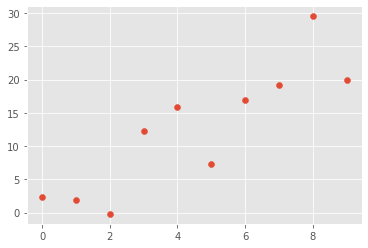

In [108]:
x, y = sim_data()

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.scatter(x, y)

----

## 简单前馈神经网络